In [5]:
from conf import *
from pathlib import Path
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from functools import wraps

In [6]:
#Set the path of the data rather than in local.
base= Path('.')
DATA_DIR = base / "data" / "clean"
DATA_DIR.mkdir(parents=True, exist_ok=True)

DATA_URL = "https://orca.casa.ucl.ac.uk/~jreades/data/20250615-London-listings.csv.gz"
DATA_PATH = DATA_DIR / "20250615-London-listings.csv.gz"

In [7]:
#Wrap the download data function with the decorator.
def check_cache(f):
    @wraps(f)
    def wrapper(src, dest):
        dest = Path(dest)
        if dest.exists() and dest.is_file():
            print(f"{dest} found locally!")
            return dest
        else:
            print(f"{dest} not found, downloading!")
            return f(src, dest)
    return wrapper

@check_cache
def download_data(src, dest):
    dest = Path(dest)
    dest.parent.mkdir(parents=True, exist_ok=True)
    response = urlopen(src)
    with dest.open("wb") as f:
        f.write(response.read())
    print(f"Data written to {dest}!")
    return dest

def load_listings():
    local_path = download_data(DATA_URL, DATA_PATH)
    return pd.read_csv(local_path)

# print a few for test.
df = load_listings()
df.head()

data/clean/20250615-London-listings.csv.gz not found, downloading!
Data written to data/clean/20250615-London-listings.csv.gz!


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,264776,https://www.airbnb.com/rooms/264776,20250610032232,2025-06-11,city scrape,Huge Four Bedroom Apartment,An extremely large and sunny four bedroom grou...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,4.74,4.62,4.72,NaN,t,11,11,0,0,0.51
1,264777,https://www.airbnb.com/rooms/264777,20250610032232,2025-06-11,city scrape,One Bedroom Apartment,Recently refurbished sunny one bedroom first f...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,4.25,4.54,4.42,NaN,t,11,11,0,0,0.22
2,264778,https://www.airbnb.com/rooms/264778,20250610032232,2025-06-11,city scrape,Two Bedroom Newly Refurbished Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50662093/af12...,1389063,...,4.52,4.36,4.38,NaN,t,11,11,0,0,0.43
3,264779,https://www.airbnb.com/rooms/264779,20250610032232,2025-06-11,city scrape,Refurbished Two Bedroom Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50660860/e440...,1389063,...,4.61,4.50,4.47,NaN,t,11,11,0,0,0.30
4,264780,https://www.airbnb.com/rooms/264780,20250610032232,2025-06-11,city scrape,Spacious refurbished 2 bedroom apt with balcony,Completely refurbished 2 bedroom apt to sleep ...,NaN,https://a0.muscache.com/pictures/airflow/Hosti...,1389063,...,4.74,4.37,4.59,NaN,t,11,11,0,0,0.35


In [ ]:
#Because the main analysis is based on price, 
#property type, number of listings from the landlord, 
#and number of bookable nights, we are doing some 
#data cleaning base on that.

In [12]:
#remove special character in price
df['price'] = (df['price'].astype(str)
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
        .replace("", None)
        .astype(float)
    )

In [13]:
#remove invalid prices
df = df[df['price'] > 0].copy()

In [14]:
#keep valid availability range
df = df[df['availability_365'].between(0, 365)]

In [15]:
#drop listings without spatial coordinates
df = df.dropna(subset=['latitude', 'longitude'])

In [16]:
#fill missing host listing count
df['host_total_listings_count'] = df['host_total_listings_count'].fillna(1)

In [17]:
#because there are some extreme luxury house, may set a cap on price.
df = df[df['price'] < 2000] #2000 maybe a proper price cap..

#1.Is Airbnb “Out of Control” in London

To assess whether Airbnb in London is experiencing "over control", we may say some illegal renting or pricing may causing over control. 

In [28]:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

as_markdown('#1.1', "There is a 90 days regulation(also known as short-let regulation)(https://www.nestify.co.uk/article/90-day-rule/), Short-term rentals are permitted for a maximum of 90 days a year, exceeding this period requires a special permit.  so are the Airbnb hosts against this policy will be a perspect.")

##### #1.1

>There is a 90 days regulation(also known as short-let regulation)(https://www.nestify.co.uk/article/90-day-rule/), Short-term rentals are permitted for a maximum of 90 days a year, exceeding this period requires a special permit.  so are the Airbnb hosts against this policy will be a perspect.


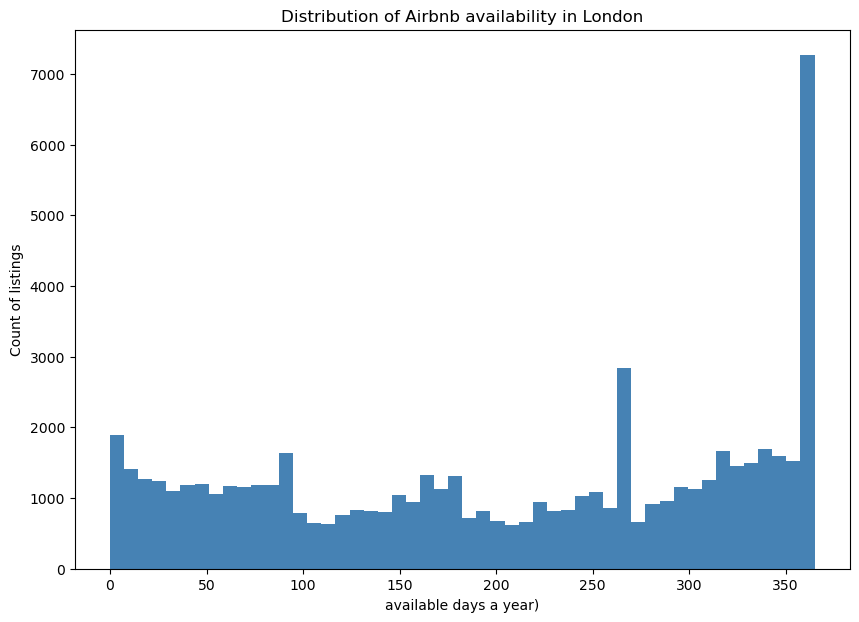

In [34]:
#The availability_365 distribution can indicate 
#whether Airbnb in London is a "seasonal short-term rental" 
#(low availability) or a "year-round operation" 
#(high availability).

# Plot distribution of availability_365
plt.figure(figsize=(10, 7))
plt.hist(df['availability_365'], bins=50, color='steelblue')
plt.xlabel("available days a year)")
plt.ylabel("Count of listings")
plt.title("Distribution of Airbnb availability in London")
plt.show()

In [35]:
#availability_365 > 90 is a potential key element
#of illegal hosting. 

#count the number of listing over 90, 180 and 300.
over_90 = (df['availability_365'] > 90)
over_180 = (df['availability_365'] > 180)
over_300 = (df['availability_365'] > 300)

print(f"Share of listings available > 90 days: {over_90.mean():.2%}")
print(f"Share of listings available > 180 days: {over_180.mean():.2%}")
print(f"Share of listings available > 300 days: {over_300.mean():.2%}")

Share of listings available > 90 days: 73.86%
Share of listings available > 180 days: 55.83%
Share of listings available > 300 days: 30.33%


In [37]:
# Compare availability patterns across room types
room_groups = df.groupby('room_type')['availability_365']

over_90_by_room = room_groups.apply(lambda x: (x > 90).mean())
print("Share of >90-day listings by room type:")
print((over_90_by_room * 100).round(2).astype(str) + "%")

Share of >90-day listings by room type:
room_type
Entire home/apt    73.72%
Hotel room         79.41%
Private room       74.01%
Shared room        87.21%
Name: availability_365, dtype: object


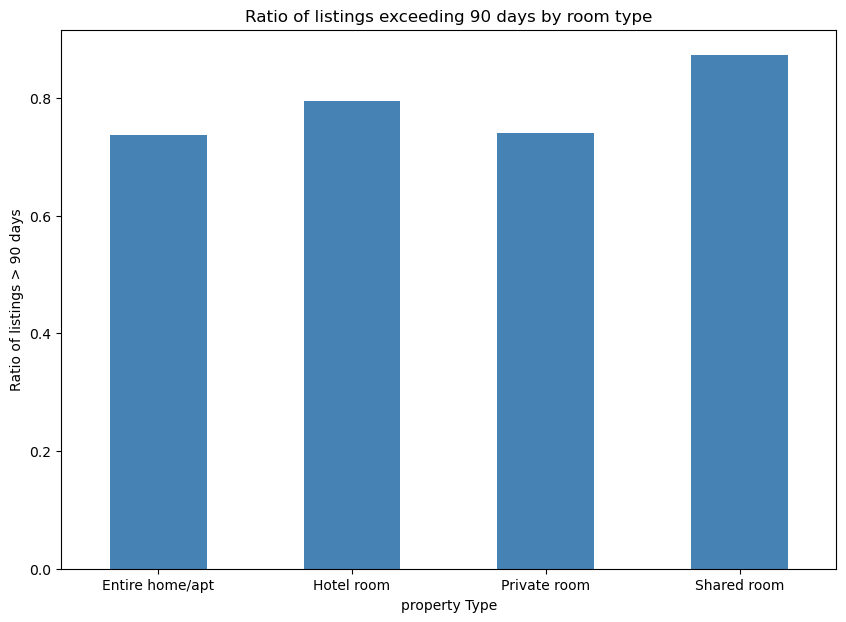

In [43]:
#plot ratio of property type >90
ax = over_90_by_room.plot(kind='bar', figsize=(10, 7), color='steelblue')
ax.set_xlabel("property Type")
ax.set_ylabel("Ratio of listings > 90 days")
ax.set_title("Ratio of listings exceeding 90 days by room type")
plt.xticks(rotation=0)
plt.show()

In [ ]:
#Also can look at the price level of those over 90 days a year.
df['over_90'] = df['availability_365'] > 90

plt.figure(figsize=(8, 5))
df.boxplot(column='price', by='over_90')
plt.title("Airbnb price distribution by >90-day availability")
plt.suptitle("")
plt.xlabel("Over 90 days available?")
plt.ylabel("Price (£)")
plt.show()

In [53]:
as_markdown('#1.2','Price level is another key aspect to indicate if airbnb out of control.')

##### #1.2

>Price level is another key aspect to indicate if airbnb out of control.


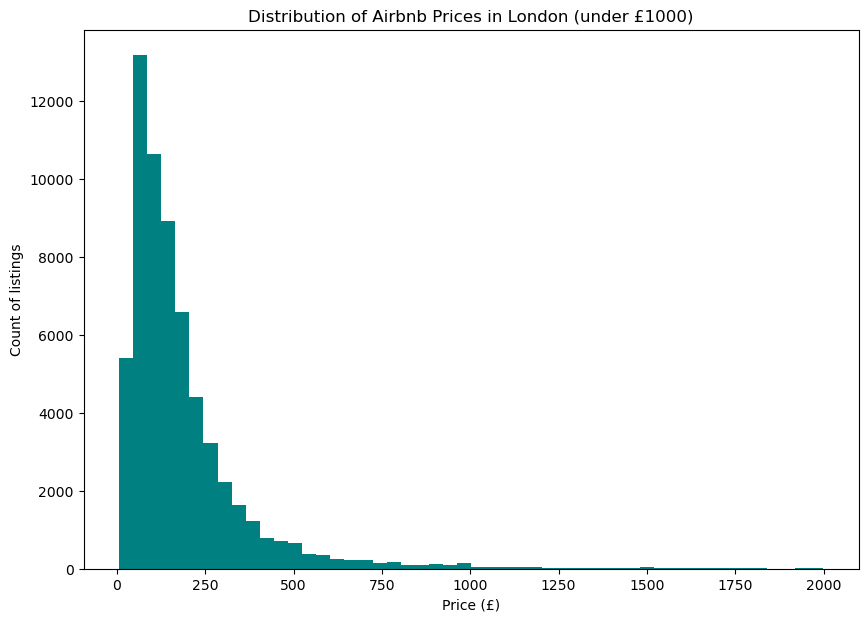

In [47]:
#Plot distribution of Airbnb prices
plt.figure(figsize=(10, 7))
plt.hist(df['price'], bins=50, color='teal')
plt.xlabel("Price (£)")
plt.ylabel("Count of listings")
plt.title("Distribution of Airbnb Prices in London (under £1000)")
plt.show()

In [48]:
#Look at some statistics on price
print("Price summary statistics:")
print(df['price'].describe())

Price summary statistics:
count    62445.000000
mean       185.369541
std        185.407696
min          6.000000
25%         75.000000
50%        134.000000
75%        224.000000
max       1999.000000
Name: price, dtype: float64


In [49]:
#We set a price level that ober 200 a night 
#could be "higher than usual", It may deviate from 
#Airbnb's original purpose.

high_price = df['price'] > 200
print(f"Share of listings priced > £200: {high_price.mean():.2%}")
#Shows price over 200 by room type.
high_price_by_type = df.groupby('room_type')['price'].apply(lambda x: (x > 200).mean())
print("\nShare of >£200 listings by room type:")
print((high_price_by_type * 100).round(2).astype(str) + "%")


Share of listings priced > £200: 29.38%

Share of >£200 listings by room type:
room_type
Entire home/apt    41.32%
Hotel room         41.18%
Private room        4.13%
Shared room         5.81%
Name: price, dtype: object


In [52]:
#Combine with the 90 days rule, count the ratio that
#satisfy over 200 a night and 90 a year.
df['over_90'] = df['availability_365'] > 90
df['high_price'] = df['price'] > 200
df['high_high'] = df['over_90'] & df['high_price']

print(f"Share of listings both >90 days and >£150: {df['high_high'].mean():.2%}")

Share of listings both >90 days and >£150: 22.91%


#2.
To assess whether Airbnb in London is experiencing "over control", we may say a host with multiple renting houses are over-commercialisation is causing over control. So start with analyzed the number of listings available from each host.

Share of hosts with >2 listings: 65.10%


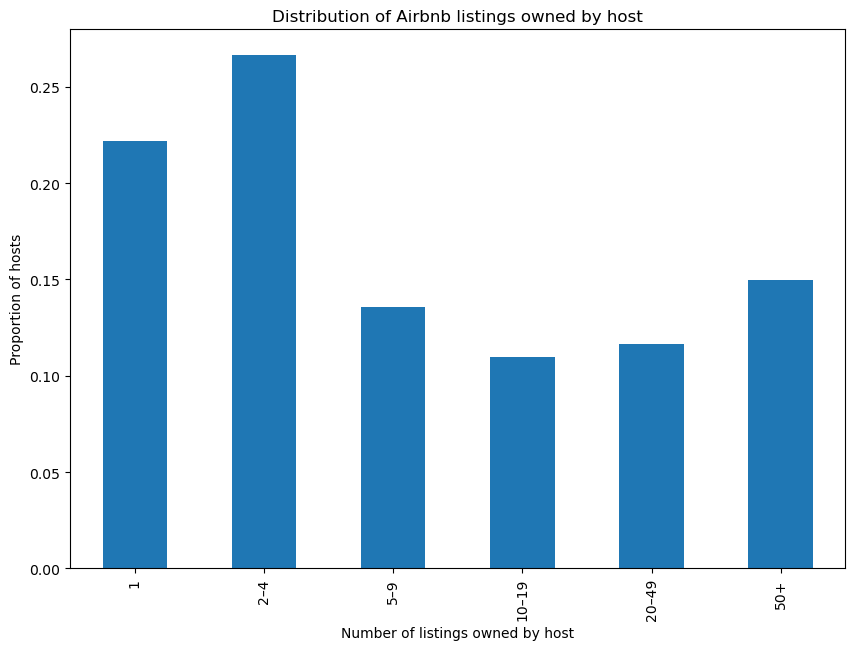

In [24]:
#calculate proportion of hosts with more than 2 listings
host_counts = df['host_total_listings_count']
multiratio = (host_counts > 2).mean()
print(f"Ratio of hosts with >2 listings: {multiratio:.2%}")

#Define bin and labels（menas how houses many a host renting)
bins = [0, 1, 4, 9, 19, 49, 999]
labels = ["1", "2–4", "5–9", "10–19", "20–49", "50+"]

# Create categorical bin column
df['host_bin'] = pd.cut(host_counts, bins=bins, labels=labels)
# Compute the ratio of hosts
dist = (df['host_bin'].value_counts(normalize=True).sort_index())
#plot
ax = dist.plot(kind='bar', figsize=(10, 7))
ax.set_xlabel("Number of listings owned by host")
ax.set_ylabel("Proportion of hosts")
ax.set_title("Distribution of Airbnb listings owned by host")
plt.show()

In [25]:
#proportion of hosts with > 2 listings
host_level = df.groupby('host_id')['host_total_listings_count'].max()
multi_host_share = (host_level > 2).mean()
print(f"Proportion of multi-lister hosts (>2 listings): {multi_host_share:.2%}")

#proportion of listings owned by multi-listers
listing_multi_share = (df['host_total_listings_count'] > 2).mean()
print(f"Proportion of listings owned by multi-listers: {listing_multi_share:.2%}")


Proportion of multi-lister hosts (>2 listings): 35.02%
Proportion of listings owned by multi-listers: 65.10%


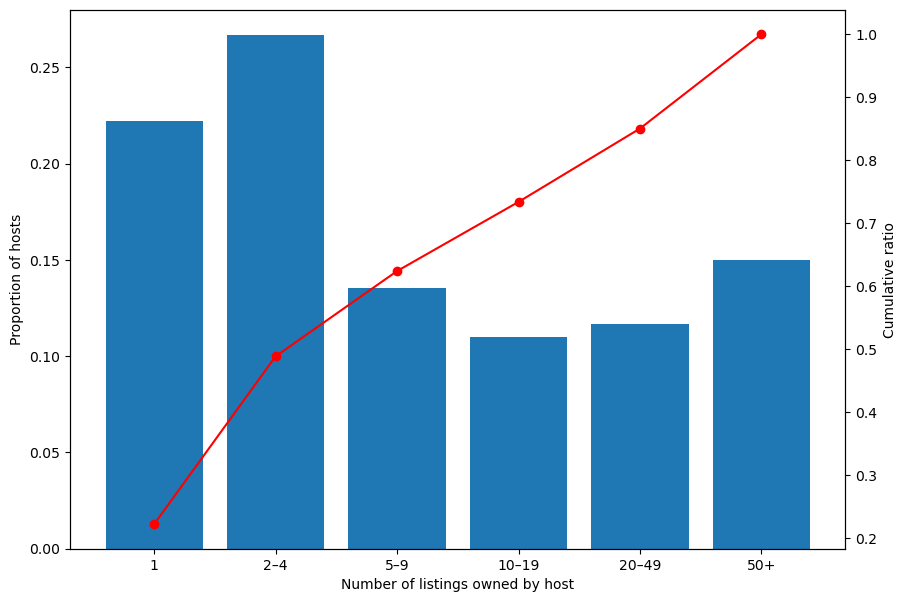

Cumulative share by bin:
host_bin
1        22.19%
2–4      48.85%
5–9      62.39%
10–19    73.37%
20–49    85.02%
50+      100.0%
Name: proportion, dtype: object


In [27]:
#Make a cumulative distribution
#compute cumulative ratio across host-size bins
cum = dist.cumsum()
#graph fitting
fig, ax1 = plt.subplots(figsize=(10, 7))
# Plot a same graph above
ax1.bar(dist.index, dist.values, label="Bin share")
ax1.set_xlabel("Number of listings owned by host")
ax1.set_ylabel("Proportion of hosts")
#Create another axis for cumulative line plot
ax2 = ax1.twinx()
ax2.plot(cum.index, cum.values, color="red", marker="o", label="Cumulative ratio")
ax2.set_ylabel("Cumulative ratio")
plt.show()
#Print cumulative ratio values
print("Cumulative share by bin:")
print((cum * 100).round(2).astype(str) + "%")


SyntaxError: invalid syntax (2045445874.py, line 1)